In [3]:
# Setup the dependencies
using Pkg; Pkg.add("Suppressor"); using Suppressor: @suppress;
@suppress Pkg.add("DotMaps")
@suppress Pkg.add(url="https://github.com/JuDO-dev/AirBorne.jl#dev")
@suppress Pkg.add(["Dates","Plots","DataFrames"])
@info "Dependencies added"

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/Documents/uni-4/FYP/fyp_repo/Project.toml`
  No Changes to `~/Documents/uni-4/FYP/fyp_repo/Manifest.toml`


┌ Info: Dependencies added
└ @ Main /Users/sherifagbabiaka/Documents/uni-4/FYP/fyp_repo/test.ipynb:6


In [1]:
using AirBorne.ETL.YFinance: get_interday_data
using Dates: DateTime,datetime2unix
# To generate this data use:
unix(x) = string(round(Int, datetime2unix(DateTime(x))))
data = get_interday_data(["AAPL", "GOOG"], unix("2017-01-01"), unix("2022-01-01"))

Row,close,high,low,open,volume,date,unix,exchangeName,timezone,currency,symbol,assetID
,Float64,Float64,Float64,Float64,Int64,DateTime,Int64,String,String,String,String,String
1,29.0375,29.0825,28.69,28.95,115127600,2017-01-03T09:30:00,1483453800,NMS,America/New_York,USD,AAPL,NMS/AAPL
2,29.005,29.1275,28.9375,28.9625,84472400,2017-01-04T09:30:00,1483540200,NMS,America/New_York,USD,AAPL,NMS/AAPL
3,29.1525,29.215,28.9525,28.98,88774400,2017-01-05T09:30:00,1483626600,NMS,America/New_York,USD,AAPL,NMS/AAPL
4,29.4775,29.54,29.1175,29.195,127007600,2017-01-06T09:30:00,1483713000,NMS,America/New_York,USD,AAPL,NMS/AAPL
5,29.7475,29.8575,29.485,29.4875,134247600,2017-01-09T09:30:00,1483972200,NMS,America/New_York,USD,AAPL,NMS/AAPL
6,29.7775,29.845,29.575,29.6925,97848400,2017-01-10T09:30:00,1484058600,NMS,America/New_York,USD,AAPL,NMS/AAPL
7,29.9375,29.9825,29.65,29.685,110354400,2017-01-11T09:30:00,1484145000,NMS,America/New_York,USD,AAPL,NMS/AAPL
8,29.8125,29.825,29.5525,29.725,108344800,2017-01-12T09:30:00,1484231400,NMS,America/New_York,USD,AAPL,NMS/AAPL
9,29.76,29.905,29.7025,29.7775,104447600,2017-01-13T09:30:00,1484317800,NMS,America/New_York,USD,AAPL,NMS/AAPL


In [37]:
using AirBorne.Engines.DEDS: run
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data
using DataFrames: DataFrame, groupby, combine, mean
#using AirBorne.Strategies.SMA: interday_initialize!, interday_trading_logic!
# include("./EMA.jl")
include("./MovingAverage.jl")
#using .EMA: interday_initialize!, interday_trading_logic!
using AirBorne.Structures: summarizePerformance,TimeEvent
using Dates
using DirectSearch
using PaddedViews

#  in a given amount of time, how many local optima can we find?
# consider using smoothing data optimisers
# noisy data optimisers - DirectSerarch -> compare with derivative based/noise sensitive

function weightings(prices, window)
    weights = [1,2,4,8,16]
    price_window = last(prices, length(weights))
    # price_window = PaddedView(0.0, price_window, window)
    # print(price_window)
    tmp = sum(weights .* price_window) / sum(weights)
    return sum(weights .* price_window) / sum(weights)
    #return mean(last(prices, window))
end
# try interpolation for custom weights -> structure may not be clear
function get_obj(time_data)
    function obj(x)
        avg_initialize!(context) = MovingAverage.interday_initialize!(context; 
            longHorizon=x[2], shortHorizon=x[1], initialCapital=10^4, averagingType=:exponential)
        avg_trading_logic! = MovingAverage.interday_trading_logic!
        # Run Simulation
        # max_iter = 100
    
        evalEvents = [
                TimeEvent(t, "data_transfer") for t in sort(unique(time_data.date); rev=true)
            ]
    
        @time context = run(
            time_data,
            avg_initialize!,
            avg_trading_logic!,
            execute_orders!,
            expose_data;
            audit=true,
            max_date=data[end, :date],
            verbose=false,
            initialEvents=evalEvents,
        )
    
        results = summarizePerformance(time_data, context)
        # print(results)
        return -results.dollarValue[end]
    end
    return obj
end

function event_func!(context)
    if context.extra.counter > 100
        curr_date = context.current_event.date
        # .&& (data[!,:date] .>= (curr_date-Dates.Day(100))
        avail_dates =((data[!,:date] .<= curr_date) )
        optimise_data = data[avail_dates, :]
        p = DSProblem(2, objective=get_obj(optimise_data))
        SetInitialPoint(p, [1.0, 100.0])
        SetGranularity(p, [1, 1])
        slcond(x) = x[1] < x[2]
        valcond(x) = x[1] > 0 && x[2] > 0 && x[1] <= 100 && x[2] <= 100
        AddExtremeConstraint(p, slcond)
        AddExtremeConstraint(p, valcond)
        Optimize!(p)
        context.extra.long_horizon = p.x[2]
        context.extra.short_horizon = p.x[1]
        context.extra.counter = 0
    end
    context.extra.counter += 1
end 


function sma_init!(context)
    context.extra.counter = 0
    MovingAverage.interday_initialize!(context; 
        longHorizon=30, shortHorizon=10, initialCapital=10^4, averagingType=:exponential, nextEventFun=event_func!)
end 
my_trading_logic!(context, data; nextEventFun=nothing) = MovingAverage.interday_trading_logic!(context, data; nextEventFun=event_func!)
evaluationEvents = [
    TimeEvent(t, "data_transfer") for t in sort(unique(data.date); rev=true)
]
@time context = run(
    data,
    sma_init!,
    my_trading_logic!,
    execute_orders!,
    expose_data;
    audit=true,
    max_date=data[end, :date],
    verbose=false,
    initialEvents=evaluationEvents,
)

results = summarizePerformance(data, context)

# try fixing one var and optimising the other -> compute derivatives: if similar maybe a mixed integer LP
# JuMP.jl -> zygote.jl, reverse dif, forward dif
# Flux.jl -> auto dif
println("Done")
println("final dollar value: ", results.dollarValue[end])
# p = DSProblem(2, objective=obj)
# # x is a vector of length 2, containing the window sizes in the form (short, long)
# # obj(x) = sum(ema(data.close, x[1]) .- ema(data.close, x[2]))
# SetInitialPoint(p, [1.0, 100.0])
# SetGranularity(p, [1, 1])
# slcond(x) = x[1] < x[2]
# valcond(x) = x[1] > 0 && x[2] > 0 && x[1] <= 100 && x[2] <= 100
# AddExtremeConstraint(p, slcond)
# AddExtremeConstraint(p, valcond)
# Optimize!(p)

  0.190856 seconds (173.92 k allocations: 14.067 MiB, 61.11% compilation time)
  0.073367 seconds (105.91 k allocations: 9.663 MiB)


  1.013872 seconds (108.38 k allocations: 9.650 MiB, 92.61% gc time)
  0.060905 seconds (108.67 k allocations: 9.853 MiB)


  0.119164 seconds (113.83 k allocations: 9.973 MiB)


  0.085663 seconds (127.46 k allocations: 10.720 MiB)


  0.073303 seconds (130.68 k allocations: 11.110 MiB)


  0.061194 seconds (116.97 k allocations: 10.356 MiB)
  0.073450 seconds (130.64 k allocations: 11.106 MiB)


  0.075408 seconds (130.18 k allocations: 10.862 MiB)


  0.066262 seconds (124.73 k allocations: 10.574 MiB)


  0.065819 seconds (127.95 k allocations: 10.966 MiB)
  0.078046 seconds (127.90 k allocations: 10.962 MiB)


  0.077434 seconds (131.77 k allocations: 11.166 MiB)


  0.086635 seconds (130.18 k allocations: 10.862 MiB)


  0.077324 seconds (129.04 k allocations: 11.025 MiB)


  0.079665 seconds (130.13 k allocations: 11.082 MiB)
  0.080253 seconds (128.50 k allocations: 10.774 MiB)


  0.079360 seconds (129.05 k allocations: 11.026 MiB)


  0.162119 seconds (131.77 k allocations: 11.166 MiB, 51.33% gc time)
  0.072079 seconds (131.76 k allocations: 10.942 MiB)


  0.079923 seconds (129.59 k allocations: 11.054 MiB)


  0.072093 seconds (131.77 k allocations: 11.166 MiB)


  0.075075 seconds (132.31 k allocations: 11.194 MiB)
  0.069572 seconds (131.22 k allocations: 10.914 MiB)


  0.159362 seconds (132.32 k allocations: 11.195 MiB)


  0.078760 seconds (131.91 k allocations: 10.945 MiB)
MADS Run Summary
-------------------------------------------------
Feasible Solution           [1.0, 4.0]
Feasible Cost               -11869.200134277344
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  62
Function Evaluations        27
Cache hits                  122
Optimization Status         Mesh Precision limit

Runtime                     3.5451929569244385
Search Time                 6.347999999999998e-6
Poll Time                   0.0034722389999999994
Blackbox Evaluation Time    3.129620799000001


  0.124892 seconds (278.98 k allocations: 29.239 MiB)


  0.151049 seconds (280.00 k allocations: 30.116 MiB)


  0.215883 seconds (281.75 k allocations: 29.413 MiB, 37.14% gc time)


  0.145374 seconds (287.21 k allocations: 29.736 MiB)


  0.144723 seconds (293.76 k allocations: 30.961 MiB)


  0.155278 seconds (300.83 k allocations: 30.484 MiB)


  0.153704 seconds (301.99 k allocations: 31.415 MiB)


  0.139889 seconds (295.38 k allocations: 30.190 MiB)


  0.217827 seconds (304.73 k allocations: 31.559 MiB, 27.71% gc time)


  0.144964 seconds (299.24 k allocations: 31.265 MiB)


  0.131347 seconds (298.11 k allocations: 30.338 MiB)


  0.193328 seconds (301.99 k allocations: 31.415 MiB)


  0.133987 seconds (303.55 k allocations: 30.625 MiB)


  0.142379 seconds (304.72 k allocations: 31.559 MiB)


  0.199631 seconds (303.63 k allocations: 31.503 MiB, 28.26% gc time)


  0.156178 seconds (305.81 k allocations: 31.615 MiB)


  0.148461 seconds (304.64 k allocations: 30.682 MiB)


  0.142867 seconds (301.93 k allocations: 30.541 MiB)


  0.138031 seconds (303.09 k allocations: 31.474 MiB)


  0.138964 seconds (303.09 k allocations: 31.475 MiB)


  0.202787 seconds (305.81 k allocations: 31.615 MiB, 26.39% gc time)


  0.159412 seconds (305.27 k allocations: 31.587 MiB)


  0.139745 seconds (305.81 k allocations: 31.615 MiB)


  0.156941 seconds (305.81 k allocations: 31.615 MiB)


  0.142959 seconds (305.81 k allocations: 31.615 MiB)


  0.153425 seconds (306.36 k allocations: 31.643 MiB)


  0.284084 seconds (305.82 k allocations: 31.615 MiB, 19.57% gc time)


  0.146225 seconds (306.36 k allocations: 31.643 MiB)


  0.136014 seconds (306.36 k allocations: 31.643 MiB)
MADS Run Summary
-------------------------------------------------
Feasible Solution           [3.0, 4.0]
Feasible Cost               -11993.349838256836
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  62
Function Evaluations        29
Cache hits                  125
Optimization Status         Mesh Precision limit

Runtime                     4.689954996109009
Search Time                 6.281999999999999e-6
Poll Time                   0.0034209349999999995
Blackbox Evaluation Time    4.559436142000001


  0.205245 seconds (500.33 k allocations: 55.850 MiB)


  0.265158 seconds (502.15 k allocations: 58.204 MiB, 20.67% gc time)


  0.220413 seconds (503.11 k allocations: 56.026 MiB)


  0.207915 seconds (504.92 k allocations: 58.394 MiB)


  0.284260 seconds (508.56 k allocations: 56.348 MiB, 19.24% gc time)


  0.224019 seconds (515.92 k allocations: 59.049 MiB)


  0.209594 seconds (522.19 k allocations: 57.096 MiB)


  0.275155 seconds (516.74 k allocations: 56.802 MiB, 19.57% gc time)


  0.224690 seconds (526.88 k allocations: 59.647 MiB)


  0.218989 seconds (513.17 k allocations: 58.894 MiB)


  0.275948 seconds (526.88 k allocations: 59.647 MiB, 19.35% gc time)


  0.229037 seconds (521.40 k allocations: 59.354 MiB)


  0.276030 seconds (524.15 k allocations: 59.503 MiB)


  0.255172 seconds (527.43 k allocations: 59.676 MiB)


  0.294590 seconds (527.97 k allocations: 59.704 MiB, 18.28% gc time)


  0.215653 seconds (524.36 k allocations: 57.210 MiB)


  0.217740 seconds (525.25 k allocations: 59.563 MiB)


  0.277542 seconds (527.97 k allocations: 59.704 MiB, 20.19% gc time)


  0.219194 seconds (525.99 k allocations: 57.294 MiB)


  0.228266 seconds (526.88 k allocations: 59.647 MiB)


  0.276389 seconds (524.91 k allocations: 57.238 MiB, 19.04% gc time)


  0.226353 seconds (527.43 k allocations: 59.676 MiB)


  0.224582 seconds (528.52 k allocations: 59.732 MiB)


  0.297467 seconds (526.92 k allocations: 57.329 MiB, 17.82% gc time)


  0.228050 seconds (527.43 k allocations: 59.676 MiB)


  0.233809 seconds (528.52 k allocations: 59.731 MiB)


  0.285128 seconds (526.84 k allocations: 57.321 MiB, 18.95% gc time)


  0.232564 seconds (528.52 k allocations: 59.732 MiB)


  0.218270 seconds (527.27 k allocations: 57.370 MiB)


  0.326553 seconds (527.98 k allocations: 59.704 MiB, 16.03% gc time)
MADS Run Summary
------------------------------------------------
Feasible Solution           [1.0, 4.0]
Feasible Cost               -13668.999862670897
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  64
Function Evaluations        30
Cache hits                  132
Optimization Status         Mesh Precision limit

Runtime                     7.441739082336426
Search Time                 9.381000000000002e-6
Poll Time                   0.004052220999999998
Blackbox Evaluation Time    7.229063262999998


  0.288934 seconds (769.39 k allocations: 88.576 MiB)


  0.356690 seconds (772.03 k allocations: 92.407 MiB, 14.82% gc time)


  0.293206 seconds (772.17 k allocations: 88.751 MiB)


  0.351639 seconds (777.63 k allocations: 89.074 MiB, 14.61% gc time)


  0.310117 seconds (791.28 k allocations: 93.556 MiB)


  0.374028 seconds (788.54 k allocations: 93.405 MiB, 14.35% gc time)


  0.350137 seconds (794.03 k allocations: 93.706 MiB)


  0.353901 seconds (785.80 k allocations: 89.528 MiB, 13.80% gc time)


  0.297283 seconds (777.55 k allocations: 92.779 MiB)


  0.360400 seconds (788.53 k allocations: 89.676 MiB, 15.10% gc time)


  0.328963 seconds (796.76 k allocations: 93.850 MiB)


  0.343288 seconds (772.03 k allocations: 92.407 MiB, 15.33% gc time)


  0.394379 seconds (783.05 k allocations: 93.096 MiB)


  0.371620 seconds (794.02 k allocations: 93.706 MiB, 14.54% gc time)


  0.326385 seconds (791.28 k allocations: 93.556 MiB)


  0.373836 seconds (796.76 k allocations: 93.850 MiB, 13.96% gc time)


  0.315744 seconds (794.02 k allocations: 93.706 MiB)


  0.362677 seconds (796.76 k allocations: 93.850 MiB, 14.09% gc time)


  0.309476 seconds (797.85 k allocations: 93.906 MiB)


  0.350622 seconds (795.67 k allocations: 93.793 MiB, 15.43% gc time)


  0.334567 seconds (795.12 k allocations: 93.765 MiB)


  0.360542 seconds (797.85 k allocations: 93.906 MiB, 14.88% gc time)


  0.335319 seconds (795.12 k allocations: 93.765 MiB)


  0.352349 seconds (797.30 k allocations: 93.878 MiB, 14.40% gc time)


  0.313706 seconds (797.85 k allocations: 93.906 MiB)


  0.356759 seconds (798.39 k allocations: 93.934 MiB, 14.66% gc time)


  0.308432 seconds (797.30 k allocations: 93.878 MiB)


  0.425049 seconds (796.76 k allocations: 93.850 MiB, 11.50% gc time)


  0.302964 seconds (794.51 k allocations: 89.991 MiB)


  0.365445 seconds (797.85 k allocations: 93.906 MiB, 14.96% gc time)


  0.352054 seconds (797.85 k allocations: 93.906 MiB)


  0.394768 seconds (797.85 k allocations: 93.906 MiB, 15.45% gc time)


  0.313948 seconds (798.39 k allocations: 93.934 MiB)


  0.365809 seconds (798.39 k allocations: 93.934 MiB, 14.34% gc time)
MADS Run Summary
-------------------------------------------------
Feasible Solution           [3.0, 4.0]
Feasible Cost               -14639.10026550293
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  64
Function Evaluations        34
Cache hits                  117
Optimization Status         Mesh Precision limit

Runtime                     11.794219017028809
Search Time                 6.649e-6
Poll Time                   0.0035630040000000007
Blackbox Evaluation Time    11.498247040999994


  0.425710 seconds (1.08 M allocations: 128.818 MiB, 13.09% gc time)


  0.388714 seconds (1.09 M allocations: 134.314 MiB)


  0.445383 seconds (1.09 M allocations: 134.656 MiB, 11.16% gc time)


  0.436744 seconds (1.10 M allocations: 135.423 MiB, 12.00% gc time)


  0.385907 seconds (1.09 M allocations: 134.814 MiB)


  0.453125 seconds (1.10 M allocations: 135.424 MiB, 13.02% gc time)


  0.421906 seconds (1.09 M allocations: 134.656 MiB, 11.88% gc time)


  0.434608 seconds (1.10 M allocations: 129.770 MiB, 12.57% gc time)


  0.456820 seconds (1.10 M allocations: 135.122 MiB)


  0.430250 seconds (1.10 M allocations: 135.274 MiB, 10.99% gc time)


  0.441659 seconds (1.10 M allocations: 135.274 MiB, 12.41% gc time)


  0.398109 seconds (1.11 M allocations: 135.567 MiB)


  0.454940 seconds (1.11 M allocations: 135.568 MiB, 11.88% gc time)


  0.464928 seconds (1.10 M allocations: 135.274 MiB, 11.16% gc time)


  0.452379 seconds (1.10 M allocations: 135.424 MiB, 12.08% gc time)


  0.397768 seconds (1.11 M allocations: 135.596 MiB)


  0.446114 seconds (1.11 M allocations: 135.483 MiB, 11.44% gc time)


  0.455574 seconds (1.11 M allocations: 135.511 MiB, 11.20% gc time)


  0.453495 seconds (1.11 M allocations: 135.595 MiB, 11.62% gc time)


  0.408077 seconds (1.10 M allocations: 130.229 MiB)


  0.439436 seconds (1.11 M allocations: 135.453 MiB, 11.67% gc time)


  0.442660 seconds (1.11 M allocations: 135.595 MiB, 12.08% gc time)


  0.392827 seconds (1.11 M allocations: 135.624 MiB)


  0.538238 seconds (1.11 M allocations: 135.539 MiB, 11.23% gc time)


  0.462367 seconds (1.11 M allocations: 135.483 MiB, 11.50% gc time)


  0.443971 seconds (1.11 M allocations: 135.624 MiB, 11.12% gc time)


  0.386941 seconds (1.10 M allocations: 130.260 MiB)


  0.428983 seconds (1.11 M allocations: 135.540 MiB, 11.54% gc time)


  0.453077 seconds (1.11 M allocations: 135.651 MiB, 11.54% gc time)


  0.419085 seconds (1.11 M allocations: 130.390 MiB)


  0.439446 seconds (1.10 M allocations: 130.233 MiB, 11.49% gc time)


  0.431136 seconds (1.11 M allocations: 135.595 MiB, 11.52% gc time)


  0.434107 seconds (1.11 M allocations: 135.568 MiB, 11.46% gc time)


  0.409101 seconds (1.11 M allocations: 135.624 MiB)


  0.462329 seconds (1.11 M allocations: 130.290 MiB, 10.95% gc time)


  0.430343 seconds (1.11 M allocations: 135.652 MiB, 11.96% gc time)


  0.390220 seconds (1.11 M allocations: 135.651 MiB)


  0.429064 seconds (1.11 M allocations: 130.289 MiB, 11.65% gc time)


  0.509514 seconds (1.10 M allocations: 130.260 MiB, 9.79% gc time)
MADS Run Summary
-------------------------------------------------
Feasible Solution           [1.0, 4.0]
Feasible Cost               -13634.349822998047
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  64
Function Evaluations        39
Cache hits                  121
Optimization Status         Mesh Precision limit

Runtime                     17.1216139793396
Search Time                 6.823999999999998e-6
Poll Time                   0.0033601439999999994
Blackbox Evaluation Time    16.687699504000072


  0.531851 seconds (1.43 M allocations: 175.144 MiB, 9.58% gc time)


  0.525171 seconds (1.43 M allocations: 175.319 MiB, 9.05% gc time)


  0.510014 seconds (1.44 M allocations: 181.927 MiB, 9.88% gc time)


  0.545162 seconds (1.44 M allocations: 182.299 MiB, 9.48% gc time)


  0.516016 seconds (1.44 M allocations: 175.641 MiB, 9.24% gc time)


  0.522185 seconds (1.45 M allocations: 183.077 MiB, 9.54% gc time)


  0.527567 seconds (1.46 M allocations: 183.226 MiB, 9.40% gc time)


  0.531728 seconds (1.44 M allocations: 182.458 MiB, 9.60% gc time)


  0.540154 seconds (1.45 M allocations: 182.616 MiB, 9.93% gc time)


  0.599394 seconds (1.46 M allocations: 183.226 MiB, 8.83% gc time)


  0.547412 seconds (1.45 M allocations: 182.925 MiB, 9.62% gc time)


  0.539645 seconds (1.46 M allocations: 183.226 MiB, 9.71% gc time)


  0.540161 seconds (1.46 M allocations: 183.370 MiB, 9.29% gc time)


  0.610553 seconds (1.45 M allocations: 183.076 MiB, 9.41% gc time)


  0.558963 seconds (1.46 M allocations: 183.370 MiB, 9.77% gc time)


  0.633902 seconds (1.46 M allocations: 183.370 MiB, 9.11% gc time)


  0.534145 seconds (1.46 M allocations: 183.426 MiB, 9.81% gc time)


  0.557674 seconds (1.46 M allocations: 183.286 MiB, 8.95% gc time)


  0.621051 seconds (1.46 M allocations: 183.286 MiB, 12.50% gc time)


  0.561723 seconds (1.46 M allocations: 183.286 MiB, 9.72% gc time)


  0.576767 seconds (1.46 M allocations: 183.398 MiB, 9.15% gc time)


  0.634873 seconds (1.46 M allocations: 183.454 MiB, 8.71% gc time)


  0.482805 seconds (1.46 M allocations: 183.398 MiB)


  0.507832 seconds (1.46 M allocations: 183.426 MiB)


  0.540536 seconds (1.46 M allocations: 183.370 MiB, 9.12% gc time)


  1.226285 seconds (1.46 M allocations: 176.615 MiB, 5.56% gc time)


  0.559948 seconds (1.46 M allocations: 183.454 MiB, 9.84% gc time)


  0.583591 seconds (1.46 M allocations: 183.426 MiB, 9.59% gc time)


  0.549181 seconds (1.46 M allocations: 183.426 MiB, 9.54% gc time)


  0.567476 seconds (1.46 M allocations: 183.426 MiB, 9.78% gc time)


  0.542876 seconds (1.46 M allocations: 183.454 MiB, 9.59% gc time)
MADS Run Summary
------------------------------------------------
Feasible Solution           [3.0, 4.0]
Feasible Cost               -13066.500091552734
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  64
Function Evaluations        31
Cache hits                  118
Optimization Status         Mesh Precision limit

Runtime                     18.008093118667603
Search Time                 6.459000000000001e-6
Poll Time                   0.003319222999999999
Blackbox Evaluation Time    17.46860167200003


  0.605086 seconds (1.82 M allocations: 227.575 MiB, 8.08% gc time)


  0.647918 seconds (1.83 M allocations: 236.052 MiB, 8.31% gc time)


  0.648909 seconds (1.83 M allocations: 236.052 MiB, 7.89% gc time)


  0.709402 seconds (1.84 M allocations: 236.394 MiB, 14.93% gc time)


  0.618734 seconds (1.85 M allocations: 228.820 MiB, 7.91% gc time)


  0.631714 seconds (1.85 M allocations: 236.860 MiB, 7.85% gc time)


  0.626682 seconds (1.83 M allocations: 236.235 MiB, 7.69% gc time)


  0.693177 seconds (1.84 M allocations: 228.527 MiB, 14.36% gc time)


  0.633795 seconds (1.85 M allocations: 237.012 MiB, 8.78% gc time)


  0.629568 seconds (1.85 M allocations: 237.162 MiB, 7.75% gc time)


  0.661911 seconds (1.85 M allocations: 228.962 MiB, 7.56% gc time)


  0.688829 seconds (1.84 M allocations: 228.674 MiB, 15.58% gc time)


  0.676399 seconds (1.85 M allocations: 237.306 MiB, 7.57% gc time)


  0.619967 seconds (1.85 M allocations: 229.023 MiB, 8.00% gc time)


  0.676316 seconds (1.85 M allocations: 228.878 MiB, 7.62% gc time)


  0.638941 seconds (1.85 M allocations: 237.277 MiB, 7.57% gc time)


  0.647265 seconds (1.85 M allocations: 237.334 MiB, 7.73% gc time)


  0.647849 seconds (1.85 M allocations: 237.278 MiB, 7.63% gc time)


  0.637768 seconds (1.85 M allocations: 237.306 MiB, 7.68% gc time)


  0.700728 seconds (1.86 M allocations: 237.362 MiB, 14.48% gc time)


  0.661040 seconds (1.85 M allocations: 228.990 MiB, 8.14% gc time)


  0.661873 seconds (1.85 M allocations: 229.258 MiB, 7.63% gc time)


  0.633273 seconds (1.85 M allocations: 237.278 MiB, 7.88% gc time)


  0.682044 seconds (1.85 M allocations: 237.334 MiB, 15.02% gc time)


  0.655370 seconds (1.86 M allocations: 237.389 MiB, 8.06% gc time)


  0.637099 seconds (1.85 M allocations: 237.305 MiB, 7.78% gc time)


  0.620678 seconds (1.85 M allocations: 229.041 MiB, 8.15% gc time)


  0.676676 seconds (1.85 M allocations: 229.018 MiB, 14.76% gc time)


  0.689017 seconds (1.86 M allocations: 237.390 MiB, 7.27% gc time)


  0.630474 seconds (1.86 M allocations: 237.361 MiB, 8.16% gc time)


  0.645892 seconds (1.86 M allocations: 237.390 MiB, 7.79% gc time)


  0.716537 seconds (1.85 M allocations: 229.046 MiB, 14.86% gc time)
MADS Run Summary
-------------------------------------------------
Feasible Solution           [1.0, 4.0]
Feasible Cost               -16318.576049804686
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  64
Function Evaluations        32
Cache hits                  124
Optimization Status         Mesh Precision limit

Runtime                     21.1441490650177
Search Time                 9.514000000000002e-6
Poll Time                   0.0033478209999999995
Blackbox Evaluation Time    20.530809681999965


  0.714210 seconds (2.26 M allocations: 288.750 MiB, 6.84% gc time)


  0.847393 seconds (2.27 M allocations: 301.527 MiB, 12.86% gc time)


  0.820893 seconds (2.26 M allocations: 301.338 MiB, 12.28% gc time)


  0.727637 seconds (2.27 M allocations: 301.869 MiB, 6.78% gc time)


  0.785149 seconds (2.28 M allocations: 289.995 MiB, 13.10% gc time)


  0.747518 seconds (2.28 M allocations: 302.182 MiB, 6.69% gc time)


  0.869398 seconds (2.28 M allocations: 302.182 MiB, 11.44% gc time)


  0.813861 seconds (2.28 M allocations: 302.487 MiB, 12.54% gc time)


  0.758752 seconds (2.27 M allocations: 289.702 MiB, 6.81% gc time)


  0.783815 seconds (2.29 M allocations: 302.637 MiB, 13.26% gc time)


  0.734540 seconds (2.28 M allocations: 289.850 MiB, 6.67% gc time)


  0.787177 seconds (2.29 M allocations: 302.637 MiB, 12.49% gc time)


  0.734352 seconds (2.28 M allocations: 290.137 MiB, 6.77% gc time)


  0.790899 seconds (2.28 M allocations: 302.487 MiB, 13.35% gc time)


  0.797197 seconds (2.29 M allocations: 302.777 MiB, 12.38% gc time)


  0.722136 seconds (2.28 M allocations: 290.200 MiB, 6.58% gc time)


  0.774833 seconds (2.28 M allocations: 290.053 MiB, 12.61% gc time)


  0.768938 seconds (2.29 M allocations: 302.752 MiB, 6.28% gc time)


  0.867783 seconds (2.28 M allocations: 290.213 MiB, 20.54% gc time)


  0.790710 seconds (2.29 M allocations: 302.607 MiB, 12.83% gc time)


  0.737780 seconds (2.28 M allocations: 290.024 MiB, 6.61% gc time)


  0.799946 seconds (2.29 M allocations: 302.696 MiB, 12.73% gc time)


  0.751641 seconds (2.29 M allocations: 302.809 MiB, 6.34% gc time)


  0.775940 seconds (2.28 M allocations: 290.165 MiB, 14.25% gc time)


  0.727117 seconds (2.28 M allocations: 290.165 MiB, 6.50% gc time)


  0.822093 seconds (2.29 M allocations: 302.666 MiB, 11.99% gc time)


  0.803296 seconds (2.29 M allocations: 302.809 MiB, 12.69% gc time)


  0.811606 seconds (2.29 M allocations: 302.752 MiB, 6.43% gc time)


  0.786989 seconds (2.29 M allocations: 302.865 MiB, 12.67% gc time)


  0.803934 seconds (2.29 M allocations: 302.724 MiB, 12.46% gc time)


  0.830728 seconds (2.29 M allocations: 302.808 MiB, 6.03% gc time)


  0.830398 seconds (2.29 M allocations: 302.865 MiB, 12.35% gc time)


  0.741684 seconds (2.29 M allocations: 290.221 MiB, 6.37% gc time)


  0.776120 seconds (2.29 M allocations: 302.837 MiB, 12.99% gc time)


  0.797893 seconds (2.29 M allocations: 302.865 MiB, 12.99% gc time)


  0.750702 seconds (2.29 M allocations: 290.454 MiB, 7.10% gc time)


  0.784082 seconds (2.28 M allocations: 290.226 MiB, 13.09% gc time)


  0.749055 seconds (2.29 M allocations: 302.752 MiB, 7.35% gc time)


  0.805344 seconds (2.29 M allocations: 302.808 MiB, 12.96% gc time)


  0.776736 seconds (2.29 M allocations: 302.836 MiB, 6.38% gc time)
MADS Run Summary
------------------------------------------------
Feasible Solution           [1.0, 6.0]
Feasible Cost               -16257.149124145508
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  68
Function Evaluations        40
Cache hits                  134
Optimization Status         Mesh Precision limit

Runtime                     31.499978065490723
Search Time                 6.915000000000001e-6
Poll Time                   0.003492263
Blackbox Evaluation Time    30.776669178000045


  0.893541 seconds (2.73 M allocations: 358.703 MiB, 11.52% gc time)


  0.914687 seconds (2.74 M allocations: 375.590 MiB, 11.73% gc time)


  0.893182 seconds (2.74 M allocations: 358.878 MiB, 11.58% gc time)


  1.037345 seconds (2.74 M allocations: 375.780 MiB, 11.95% gc time)


  1.017023 seconds (2.74 M allocations: 359.200 MiB, 10.60% gc time)


  0.932571 seconds (2.76 M allocations: 376.889 MiB, 10.94% gc time)


  0.894247 seconds (2.75 M allocations: 376.435 MiB, 11.50% gc time)


  0.900161 seconds (2.75 M allocations: 359.655 MiB, 11.11% gc time)


  1.041609 seconds (2.75 M allocations: 376.121 MiB, 10.44% gc time)


  1.076496 seconds (2.76 M allocations: 376.588 MiB, 10.31% gc time)


  0.958031 seconds (2.76 M allocations: 377.033 MiB, 10.72% gc time)


  0.889075 seconds (2.75 M allocations: 359.802 MiB, 5.66% gc time)


  0.937617 seconds (2.75 M allocations: 376.279 MiB, 10.77% gc time)


  0.944472 seconds (2.76 M allocations: 377.033 MiB, 10.81% gc time)


  0.949301 seconds (2.76 M allocations: 376.739 MiB, 10.97% gc time)


  0.916797 seconds (2.76 M allocations: 377.033 MiB, 11.12% gc time)


  0.916055 seconds (2.76 M allocations: 376.889 MiB, 11.19% gc time)


  0.904095 seconds (2.76 M allocations: 377.033 MiB, 11.13% gc time)


  0.961368 seconds (2.76 M allocations: 376.948 MiB, 10.64% gc time)


  0.935917 seconds (2.76 M allocations: 377.005 MiB, 10.84% gc time)


  0.935594 seconds (2.77 M allocations: 377.089 MiB, 11.34% gc time)


  0.892194 seconds (2.77 M allocations: 377.089 MiB, 11.55% gc time)


  0.910096 seconds (2.77 M allocations: 377.089 MiB, 10.97% gc time)


  0.922621 seconds (2.77 M allocations: 377.089 MiB, 11.14% gc time)


  0.985799 seconds (2.77 M allocations: 377.117 MiB, 10.67% gc time)


  0.938264 seconds (2.77 M allocations: 377.061 MiB, 10.95% gc time)


  0.890462 seconds (2.77 M allocations: 377.117 MiB, 11.52% gc time)


  0.893498 seconds (2.76 M allocations: 360.415 MiB, 11.16% gc time)


  0.889484 seconds (2.77 M allocations: 377.089 MiB, 10.78% gc time)


  0.920239 seconds (2.77 M allocations: 377.117 MiB, 10.49% gc time)


  0.826131 seconds (2.76 M allocations: 360.173 MiB, 6.01% gc time)


  0.899023 seconds (2.76 M allocations: 360.165 MiB, 11.13% gc time)
MADS Run Summary
------------------------------------------------
Feasible Solution           [2.0, 4.0]
Feasible Cost               -22005.700302124023
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  62
Function Evaluations        32
Cache hits                  176
Optimization Status         Mesh Precision limit

Runtime                     30.073264837265015
Search Time                 7.003999999999999e-6
Poll Time                   0.003242402
Blackbox Evaluation Time    29.169981047000007


  1.032591 seconds (3.25 M allocations: 435.057 MiB, 10.19% gc time)


  1.067771 seconds (3.26 M allocations: 456.245 MiB, 14.05% gc time)


  1.125387 seconds (3.25 M allocations: 435.232 MiB, 9.51% gc time)


  1.047367 seconds (3.26 M allocations: 435.555 MiB, 13.23% gc time)


  1.136906 seconds (3.26 M allocations: 456.434 MiB, 14.64% gc time)


  1.097918 seconds (3.27 M allocations: 457.242 MiB, 9.95% gc time)


  1.050649 seconds (3.26 M allocations: 456.434 MiB, 13.93% gc time)


  1.027217 seconds (3.27 M allocations: 456.933 MiB, 10.47% gc time)


  1.070425 seconds (3.28 M allocations: 457.394 MiB, 9.66% gc time)


  1.123395 seconds (3.28 M allocations: 457.544 MiB, 13.83% gc time)


  1.021798 seconds (3.26 M allocations: 435.861 MiB, 10.16% gc time)


  1.080309 seconds (3.27 M allocations: 456.776 MiB, 14.67% gc time)


  1.041008 seconds (3.27 M allocations: 457.242 MiB, 9.78% gc time)


  1.057567 seconds (3.27 M allocations: 436.157 MiB, 9.42% gc time)


  1.154207 seconds (3.28 M allocations: 457.688 MiB, 14.64% gc time)


  1.058121 seconds (3.28 M allocations: 457.544 MiB, 10.10% gc time)


  1.115186 seconds (3.28 M allocations: 457.688 MiB, 13.47% gc time)


  1.117223 seconds (3.28 M allocations: 457.688 MiB, 9.94% gc time)


  1.132245 seconds (3.28 M allocations: 457.544 MiB, 13.41% gc time)


  1.018411 seconds (3.28 M allocations: 457.603 MiB, 10.23% gc time)


  1.035741 seconds (3.28 M allocations: 457.631 MiB, 9.58% gc time)


  1.054469 seconds (3.28 M allocations: 457.744 MiB, 9.73% gc time)


  1.077647 seconds (3.28 M allocations: 457.744 MiB, 9.70% gc time)


  1.108679 seconds (3.28 M allocations: 457.744 MiB, 15.73% gc time)


  1.051808 seconds (3.28 M allocations: 457.603 MiB, 9.76% gc time)


  1.135595 seconds (3.28 M allocations: 457.744 MiB, 13.57% gc time)


  1.053377 seconds (3.28 M allocations: 457.772 MiB, 10.16% gc time)


  1.158866 seconds (3.28 M allocations: 457.716 MiB, 16.66% gc time)


  1.046159 seconds (3.28 M allocations: 457.744 MiB, 10.03% gc time)


  1.395534 seconds (3.28 M allocations: 436.514 MiB, 8.60% gc time)


  1.237608 seconds (3.28 M allocations: 457.688 MiB, 13.05% gc time)


  1.058774 seconds (3.28 M allocations: 457.772 MiB, 9.40% gc time)


  1.167786 seconds (3.28 M allocations: 457.744 MiB, 13.49% gc time)


  1.029835 seconds (3.28 M allocations: 457.772 MiB, 10.13% gc time)
MADS Run Summary
-------------------------------------------------
Feasible Solution           [3.0, 4.0]
Feasible Cost               -24508.05015563965
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  64
Function Evaluations        34
Cache hits                  124
Optimization Status         Mesh Precision limit

Runtime                     37.46037197113037
Search Time                 7.441000000000002e-6
Poll Time                   0.0038576829999999985
Blackbox Evaluation Time    36.41660822700003


  1.242331 seconds (3.81 M allocations: 517.109 MiB, 17.26% gc time)


  1.160750 seconds (3.81 M allocations: 517.284 MiB, 10.06% gc time)


  1.217272 seconds (3.82 M allocations: 542.596 MiB, 13.33% gc time)


  1.296405 seconds (3.83 M allocations: 543.127 MiB, 12.37% gc time)


  1.262684 seconds (3.83 M allocations: 543.594 MiB, 12.66% gc time)


  1.214001 seconds (3.83 M allocations: 518.355 MiB, 15.47% gc time)


  1.264039 seconds (3.84 M allocations: 543.745 MiB, 13.03% gc time)


  1.134825 seconds (3.82 M allocations: 517.606 MiB, 9.62% gc time)


  1.172452 seconds (3.84 M allocations: 544.039 MiB, 12.56% gc time)


  1.261781 seconds (3.82 M allocations: 517.760 MiB, 12.43% gc time)


  1.232794 seconds (3.83 M allocations: 543.285 MiB, 13.09% gc time)


  1.283848 seconds (3.84 M allocations: 543.745 MiB, 12.56% gc time)


  1.199999 seconds (3.84 M allocations: 543.895 MiB, 13.23% gc time)


  1.198475 seconds (3.84 M allocations: 543.895 MiB, 13.31% gc time)


  1.267546 seconds (3.84 M allocations: 544.039 MiB, 13.33% gc time)


  1.184598 seconds (3.84 M allocations: 543.954 MiB, 9.26% gc time)


  1.202572 seconds (3.84 M allocations: 544.039 MiB, 8.46% gc time)


  1.223569 seconds (3.84 M allocations: 544.095 MiB, 14.29% gc time)


  1.228507 seconds (3.84 M allocations: 544.095 MiB, 12.40% gc time)


  1.221927 seconds (3.84 M allocations: 544.095 MiB, 13.08% gc time)


  1.373251 seconds (3.84 M allocations: 544.095 MiB, 11.82% gc time)


  1.282653 seconds (3.84 M allocations: 544.123 MiB, 12.79% gc time)


  1.309348 seconds (3.84 M allocations: 543.983 MiB, 12.66% gc time)


  1.238834 seconds (3.83 M allocations: 518.563 MiB, 13.24% gc time)


  1.162416 seconds (3.84 M allocations: 544.039 MiB, 9.96% gc time)


  1.281054 seconds (3.84 M allocations: 544.095 MiB, 11.97% gc time)


  1.179863 seconds (3.83 M allocations: 518.605 MiB, 12.93% gc time)


  1.199564 seconds (3.84 M allocations: 544.095 MiB, 13.12% gc time)


  1.237285 seconds (3.84 M allocations: 544.123 MiB, 13.94% gc time)


  1.283650 seconds (3.84 M allocations: 544.123 MiB, 12.66% gc time)


  1.184134 seconds (3.84 M allocations: 518.828 MiB, 13.48% gc time)


  1.221576 seconds (3.84 M allocations: 518.580 MiB, 8.77% gc time)


MADS Run Summary
------------------------------------------------
Feasible Solution           [2.0, 4.0]
Feasible Cost               -27784.00001525879
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  62
Function Evaluations        32
Cache hits                  173
Optimization Status         Mesh Precision limit

Runtime                     39.69112300872803
Search Time                 7.035000000000001e-6
Poll Time                   0.003326992999999999
Blackbox Evaluation Time    38.437189453000045


  1.469854 seconds (4.41 M allocations: 605.193 MiB, 18.02% gc time)


  1.458419 seconds (4.42 M allocations: 634.979 MiB, 11.80% gc time)


  1.295295 seconds (4.41 M allocations: 605.367 MiB, 12.44% gc time)


  1.384722 seconds (4.42 M allocations: 605.690 MiB, 11.96% gc time)


  1.385672 seconds (4.42 M allocations: 635.169 MiB, 15.57% gc time)


  1.543977 seconds (4.44 M allocations: 636.279 MiB, 11.17% gc time)


  1.368081 seconds (4.43 M allocations: 635.510 MiB, 15.72% gc time)


  1.326365 seconds (4.44 M allocations: 636.422 MiB, 12.59% gc time)


  1.456159 seconds (4.43 M allocations: 606.292 MiB, 11.66% gc time)


  1.319315 seconds (4.42 M allocations: 605.844 MiB, 12.19% gc time)


  2.771082 seconds (4.44 M allocations: 636.129 MiB, 16.55% gc time)


  1.659209 seconds (4.43 M allocations: 635.668 MiB, 12.08% gc time)


  1.465247 seconds (4.44 M allocations: 636.129 MiB, 14.64% gc time)


  1.317184 seconds (4.44 M allocations: 636.279 MiB, 12.33% gc time)


  1.417184 seconds (4.44 M allocations: 636.278 MiB, 11.15% gc time)


  1.394518 seconds (4.44 M allocations: 636.423 MiB, 14.78% gc time)


  1.360335 seconds (4.44 M allocations: 636.422 MiB, 11.59% gc time)


  1.412594 seconds (4.44 M allocations: 636.450 MiB, 11.93% gc time)


  1.313385 seconds (4.44 M allocations: 636.338 MiB, 12.20% gc time)


  1.423783 seconds (4.44 M allocations: 636.394 MiB, 11.41% gc time)


  1.371000 seconds (4.44 M allocations: 636.478 MiB, 15.20% gc time)


  1.425270 seconds (4.44 M allocations: 636.479 MiB, 10.94% gc time)


  1.321689 seconds (4.44 M allocations: 636.478 MiB, 11.96% gc time)


  1.469031 seconds (4.44 M allocations: 636.506 MiB, 13.99% gc time)


  1.369029 seconds (4.44 M allocations: 636.451 MiB, 11.51% gc time)


  1.472691 seconds (4.44 M allocations: 636.366 MiB, 14.48% gc time)


  1.340729 seconds (4.43 M allocations: 606.667 MiB, 11.60% gc time)


  1.403295 seconds (4.44 M allocations: 636.451 MiB, 11.67% gc time)


  1.308741 seconds (4.44 M allocations: 606.663 MiB, 12.35% gc time)


  1.488707 seconds (4.44 M allocations: 636.507 MiB, 14.35% gc time)


  1.334312 seconds (4.44 M allocations: 636.506 MiB, 12.21% gc time)


  1.372288 seconds (4.44 M allocations: 606.643 MiB, 11.44% gc time)


  1.452335 seconds (4.44 M allocations: 606.915 MiB, 15.01% gc time)
MADS Run Summary
-------------------------------------------------
Feasible Solution           [2.0, 3.0]
Feasible Cost               -31912.899398803715
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  62
Function Evaluations        33
Cache hits                  111
Optimization Status         Mesh Precision limit

Runtime                     47.97064685821533
Search Time                 7.448999999999999e-6
Poll Time                   0.0044270859999999985
Blackbox Evaluation Time    46.483688780000016


274.449665 seconds (784.13 M allocations: 100.886 GiB, 11.08% gc time, 0.58% compilation time: 23% of which was recompilation)
Done
final dollar value: 30582.199673830088


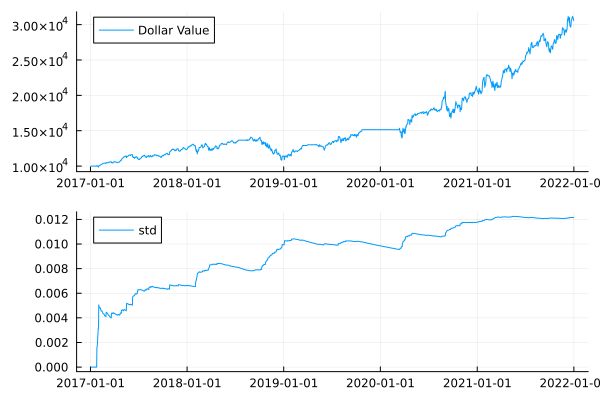

In [49]:
using Plots: plot, plot!
results = summarizePerformance(data, context, windowSize=length(data.date))

val = plot(results.date, results.dollarValue, label="Dollar Value")
std = plot(results.date, results.std_return, label="std")
plot(val, std, layout=(2,1), legend=:topleft)

In [13]:
avg_initialize!(context) = MovingAverage.interday_initialize!(context; 
        longHorizon=p.x[2], shortHorizon=p.x[1], initialCapital=10^4, averagingType=:simple)
avg_trading_logic! = MovingAverage.interday_trading_logic!
# Run Simulation
# max_iter = 100

evaluationEvents = [
        TimeEvent(t, "data_transfer") for t in sort(unique(data.date); rev=true)
    ]

@time context = run(
    data,
    avg_initialize!,
    avg_trading_logic!,
    execute_orders!,
    expose_data;
    audit=true,
    max_date=DateTime(2022, 1, 1),
    verbose=false,
    initialEvents=evaluationEvents,
)

results = summarizePerformance(data, context)

  2.842097 seconds (5.88 M allocations: 693.338 MiB, 29.66% gc time, 19.52% compilation time: 4% of which was recompilation)


Row,date,type,portfolio,account,stockValue,dollarValue,return,mean_return,std_return,sharpe
,DateTime,String,Any,Any,Dict…?,Real,Union…,Union…,Union…,Union…
1,2017-01-03T09:30:00,start,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>39.307, ""NMS/AAPL""=>29.0375)",10000,0.0,0.0,NaN,
2,2017-01-03T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>39.307, ""NMS/AAPL""=>29.0375)",10000,0.0,0.0,0.0,
3,2017-01-04T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>39.345, ""NMS/AAPL""=>29.005)",10000,0.0,0.0,0.0,
4,2017-01-05T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>39.701, ""NMS/AAPL""=>29.1525)",10000,0.0,0.0,0.0,
5,2017-01-06T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>40.3075, ""NMS/AAPL""=>29.4775)",10000,0.0,0.0,0.0,
6,2017-01-09T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>40.3325, ""NMS/AAPL""=>29.7475)",10000,0.0,0.0,0.0,
7,2017-01-10T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>40.2395, ""NMS/AAPL""=>29.7775)",10000,0.0,0.0,0.0,
8,2017-01-11T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>40.3955, ""NMS/AAPL""=>29.9375)",10000,0.0,0.0,0.0,
9,2017-01-12T09:30:00,data_transfer,"Dict{Any, Any}()","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""USD"", :balance=>10000))))","Dict(""NMS/GOOG""=>40.318, ""NMS/AAPL""=>29.8125)",10000,0.0,0.0,0.0,


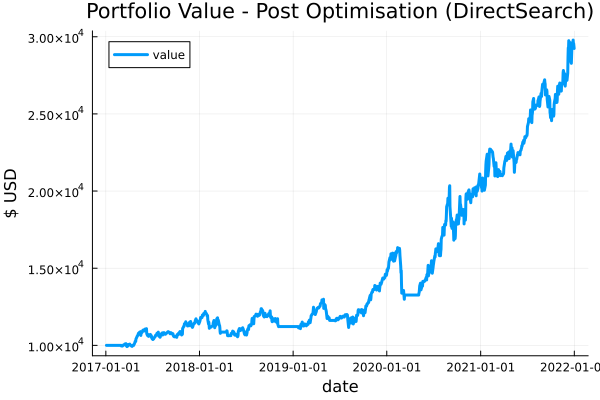

In [16]:



using Plots: plot, plot!
plot(results.date, results.dollarValue, title="Portfolio Value - Post Optimisation (DirectSearch)", label="value", linewidth=3, xlabel="date",ylabel="\$ USD")